In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from datetime import datetime

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import for loess regression
from scipy.interpolate import interp1d
import statsmodels.api as sm

In [3]:
from plotnine import*

In [4]:
df_trial = pd.read_excel('C:/Users/zhd/Documents/Work/Project/New LTV/RonFile/ACPCRaw.xlsx', 'Trial')

In [5]:
df_payg = pd.read_excel('C:/Users/zhd/Documents/Work/Project/New LTV/RonFile/ACPCRaw.xlsx', 'PAYG')

### Define Functions

In [7]:
def geometric_series (a,r,n=None):
    if r == 1:
        value = 0
    elif n:
       value = a*(1-r**n)/(1-r)
    else:
        value =  a/(1-r)
    return value

In [ ]:
def LTV (margin,acpc,r,t=None):
    if t:
       value = margin * acpc*(1-r**t)/(1-r)
    else:
        value =  margin * acpc/(1-r)
    return value

In [8]:
def series_start (s,r,n):
    return s*(1-r)/(1-(r**n)) if (1-r) else 0 

In [9]:
# def harmonic_mean(*args):
#     return np.divide(len([x for x in args if x is not None]),np.sum([1/x for x in args if x is not None]))

In [10]:
def harmonic_mean(a):
    if any([v ==0 for v in a]):
        return np.mean(a)
    else:
        return stats.hmean(a)
  

In [11]:
def compound_churn_rate (current, base, month):
    return 1 - (current/base)**(1/month)
    

### Test Function

In [12]:
# test function

ltv = geometric_series(100,0.95,10)
print(ltv)
series_start(ltv, 0.95,10)

802.5261215232418


100.0

### Calculate LTV ACPC

In [14]:
df_offer = df_payg
df_offer['cohort_date']= pd.to_datetime(df_offer['cohort'])

In [15]:
df_offerf = df_offer[df_offer['cohort_date'] >='2015-01-01']


In [17]:
df_offerf['plot_acpc'] = df_offerf['PU']/df_offerf['CCID_current']

C:\Users\zhd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


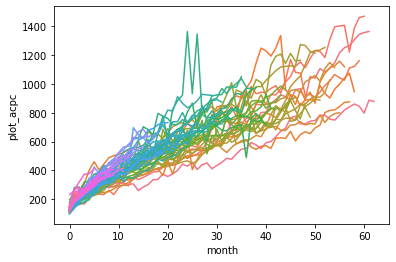

In [18]:
sns.lineplot(x='month',y='plot_acpc', hue='cohort', data=df_offerf, legend=None)
plt.legend
plt.show()

### Determin LTV ACPC

In [19]:
#df_offer = df_trial
df_offer=df_payg
df_offer['cohort_date']= pd.to_datetime(df_offer['cohort'])
df_offer = df_offer[(df_offer['cohort_date'] >= '2015-01-01') & (df_offer['cohort_date'] < '2020-03-01')]
df_offer = df_offer[['cohort','month','PU','CCID_base','CCID_current','cohort_date']]

In [20]:
df_offer['PU_cumsum']=df_offer.groupby('cohort')['PU'].cumsum()

In [21]:
df_offer['churn_compound'] = 1-(df_offer['CCID_current']/df_offer['CCID_base'])**(1/(df_offer['month']+1))

In [22]:
df_offer['acpc'] = (df_offer.apply(lambda x: series_start(x.PU_cumsum, 1-x.churn_compound, x.month+1), axis=1))/df_offer['CCID_base']

In [24]:
df_offer['ltv'] = df_offer.apply(lambda x: geometric_series(x.acpc, (1-x.churn_compound)), axis=1)

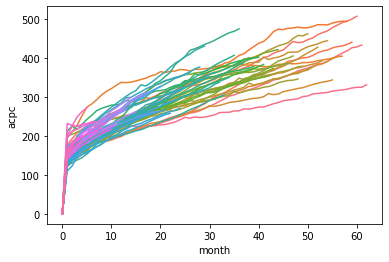

In [25]:
sns.lineplot(x='month', y='acpc',hue='cohort', data=df_offer, legend=None)

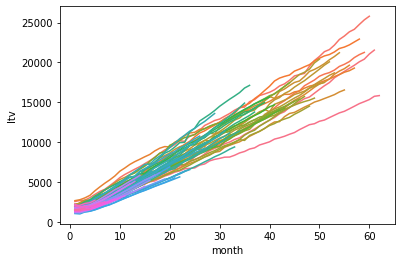

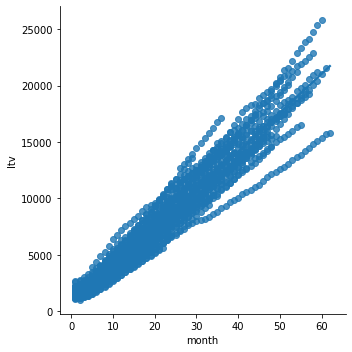

In [26]:
fig, axes=plt.subplots(1,1)
sns.lineplot(x='month', y='ltv', hue='cohort', data=df_offer[df_offer['month']>0], legend=None)
sns.lmplot(x='month', y='ltv', data=df_offer[df_offer['month']>0], lowess=True)
plt.show()

In [27]:
# LTV Growth

df_growth = df_offer
df_growth['ltv_lagged'] = df_growth.ltv - df_growth.groupby('cohort')['ltv'].shift(1)

df_growth = df_growth[df_growth['month']>1]

[]

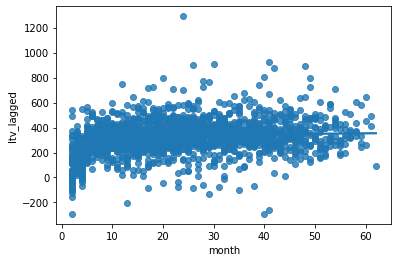

In [28]:
sns.regplot(x='month', y='ltv_lagged', data=df_growth, lowess=True)
plt.plot()

### Fitted estimates

In [29]:
# Create a linear model and/or loess model

df_fit = df_offer[df_offer.month>0]

In [32]:
df_fitdata=df_fit.groupby('month').agg({'acpc': np.nanmean, 'ltv': np.nanmean,'churn_compound': harmonic_mean}).reset_index()

In [ ]:
from scipy.interpolate import interp1d
import statsmodels.api as sm

# Model out the historical ltv in any given month, and fit them with the LOESS regression
# lowess will return "smoothed" data with a y value for every x-value
ltv_fit = sm.nonparametric.lowess(df_fitdata.ltv, df_fitdata.month)

# Unpack the lowess smoothed points to their values
lowess_x = [x for x in zip(*ltv_fit)][0]
lowess_y = [x for x in zip(*ltv_fit)][1]

# Run scipy's interpolation, and this will generate y values for any x values by our interpolator
# But it will miss values outside of the x value window 
# We can easily extend the estimates outside the x boundaries based on the patterns found here

f = interp1d(lowess_x, lowess_y, bounds_error=False)

In [39]:
new_data = [12, 18, 24, 30, 36, 48, 60, 62, 72]

In [40]:
ynew=f(new_data)
print(ynew)

[ 4665.30611375  6687.17606868  8730.03562673 10770.6178556
 12788.34063465 16850.99724763 20951.02623928 21637.06639615
            nan]


In [64]:
# Extend estimates

target_duration = 60
#forecast_horizon = 36 #Trial
forecast_horizon = 60 #PAYG
df_meangrowth = df_growth

In [66]:
mean_growth = df_meangrowth.groupby('month')['ltv_lagged'].mean().tail(12).mean()

In [67]:
f(forecast_horizon) + mean_growth * (target_duration - forecast_horizon)

20951.026239283532